In [95]:
import argparse
from pathlib import Path
from pandas import concat, DataFrame, melt, merge, read_csv, qcut, value_counts
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.text import Annotation
from matplotlib.ticker import FuncFormatter, MultipleLocator
rcParams['figure.facecolor'] = 'white'
import textwrap
from constant import CRITERIA
import itertools
import numpy as np
from functools import reduce
from adjustText import adjust_text
from math import ceil
from string import ascii_lowercase
from collections import defaultdict

In [96]:
# networks = ["RH0_only", "RH0_small", "RH0_large"]
RHs = ["RH0", "RH2"]
load_sets = ["only", "small", "large"]
seasons = ["winter", "spring", "summer", "fall"]
loadtype = ["max"]
lengths = ["short"]
all_cases = ["_".join([rh, ls, s, lo, le]) for rh, ls, s, lo, le in itertools.product(RHs, load_sets, seasons, loadtype, lengths)]

In [97]:
def assign_tech_numbers(row_name):
    new_cols = dict()
    tech_numbers = row_name.split(" & ")
    new_cols["Solar"] = int(tech_numbers[0].split(" ")[0])
    new_cols["SOFC"] = int(tech_numbers[1].split(" ")[0])
    new_cols["Diesel"] = int(tech_numbers[2].split(" ")[0])
    return new_cols

In [98]:
def get_row_bucket(row):
    solar = row["Solar"] * 3.8 # for grouping by kW capacity
    sofc = row["SOFC"] * 10  # for grouping by kW capacity
    diesel = row["Diesel"] * 10  # for grouping by kW capacity
    total = solar + sofc + diesel
    if solar > 0.5 * total:
        return 'Solar'
    elif sofc > 0.5 * total:
        return 'SOFC'
    elif diesel > 0.5 * total:
        return "Diesel"
    else:
        return "Misc"

In [99]:
from pprint import pprint
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

def understand_buckets(plotfolder, network, length, bucketed_df):
    idx = 0
    for bucket_name, bucketed_data in bucketed_df:
        figure_data = []
    
        # print(bucket_name)
        # pprint(bucketed_data.shape)
        bucketed_data["Solar kW"] = bucketed_data["Solar"] * 3.8
        bucketed_data["SOFC kW"] = bucketed_data["SOFC"] * 10
        bucketed_data["Diesel kW"] = bucketed_data["Diesel"] * 10
        breakdown_data = bucketed_data[["Solar kW", "SOFC kW", "Diesel kW"]]
        # fig = px.line_polar(r = [], breakdown_data, line_close=True)
        # fig.show()
        for row in breakdown_data.values:
            figure_data.append(go.Scatterpolar(
                    r = row,
                    theta = breakdown_data.columns.values,
                    fill='toself',
                    fillcolor="rgba(190,190,190,0.1)",
                    line={
                        "color": "rgba(190,190,190,0.1)",
                        # "width": 0.01
                    },
                    marker={
                        "color": "rgba(190,190,190,0.1)",
                        # "width": 0.01
                    }
                ))
        fig = go.Figure(
                data = figure_data,
                layout=go.Layout(
                    title=go.layout.Title(text=f'({ascii_lowercase[idx]}) {bucket_name}', x=0.5),
                    font={
                        "size":20
                    },
                    showlegend=False
                )
            )
        
        
        fig.update_layout(polar=dict(
            radialaxis=dict(
                visible=True
            )
        ))

        pyo.plot(fig)
        
        fig.write_html(plotfolder.joinpath(f"{network}_{length}_{bucket_name}.html"))

        idx += 1

In [100]:
def category_datapoint_label_formatter(crit):
    criterion_idx = CRITERIA.index(crit)
    if criterion_idx == 0:
        return lambda value: "$" + "{:,}".format(round(value/1e6, 1)) + "M"
    if criterion_idx == 1:
        return lambda value: "{:,}".format(int(int(value)/1e6)) + "M lbs"
    if criterion_idx > 1 and criterion_idx < 5:
        return lambda value: "{:,}".format(int(value)) + " lbs"
    if criterion_idx == 5:
        return lambda value: "{:.0%}".format(float(value))
    if criterion_idx == 6:
        return lambda value: "{:,}".format(abs(round(float(value)/1e6, 1))) + "M"

In [101]:
def create_box_and_whisker(datafolder, plotfolder, pad=3, figsize=(25,10), include=[True]*len(CRITERIA), network="all_branches", winter_loadtype="min", length="short", props={}, system_set="all", save_file=True):
    all_case_data = None
    for season in seasons:
        case = "_".join([network, season, winter_loadtype if season == "winter" else "max", length])
        case_filepath = datafolder.joinpath(f"{case}_{system_set}.csv")
        case_data = read_csv(case_filepath, index_col=[0])
        case_data = concat([case_data, case_data.apply(lambda row: assign_tech_numbers(row.name), axis = "columns", result_type = "expand")], axis='columns')
        all_case_data = case_data if all_case_data is None else concat([all_case_data, case_data])
    all_case_data["Bucket"] = all_case_data.aggregate(get_row_bucket, axis = 1)
    all_case_data_groupby = all_case_data.groupby("Bucket")
    understand_buckets(plotfolder, network, length, all_case_data_groupby)
    included_criteria = np.array(CRITERIA)[include]
    fig, axs = plt.subplots(2, ceil(len(included_criteria) / 2), figsize=figsize)
    axs = axs.reshape(1, ceil(len(included_criteria) / 2) * 2)[0]
    fig.tight_layout(pad=pad)
    # fig.suptitle(f"{network.replace('_', ' ').title()}, {'72 Hour' if length=='long' else '36 Hour'} Outage Duration, All Systems, Bucketed By Majority Technology", fontsize=20, y=1)
    formatter_lambda = lambda crit: FuncFormatter(lambda y_val, tick_pos: category_datapoint_label_formatter(crit)(y_val))
    for idx, criterion in enumerate(included_criteria):
        sb.boxplot(data=all_case_data, x="Bucket", y=criterion, ax=axs[idx], order = value_counts(all_case_data['Bucket']).sort_index().index, **props).set(title=f"({ascii_lowercase[idx]}) {criterion}")
        # axs[idx].set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text(),9)) for ticklabel in axs[idx].get_xticklabels()], rotation=90)
        axs[idx].set(xlabel=None)
        axs[idx].set(ylabel=None)
        axs[idx].yaxis.set_major_formatter(formatter_lambda(criterion))
        # axs[idx].set_ylim(bottom=0)
        # pass
    for ax in axs[len(CRITERIA):]:
        fig.delaxes(ax)
    if save_file:
        fig.savefig(plotfolder.joinpath(f"{network}_{length}_{system_set}.png"))

In [102]:
sb.set_theme(font_scale=1.5)

# rcParams['figure.facecolor'] = 'white'
# create_box_and_whisker(
#     network = "RH0_large",
#     length="short",
#     include = [True, True, True, True, True, True, True],
#     winter_loadtype="max", 
#     figsize=(20,10),
#     pad=3,
#     datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
#     plotfolder = Path("../../Part A/Images/BoxAndWhiskers"),
#     props={'boxprops':{'facecolor':'gray'}},
#     save_file=False)

In [103]:
def annotation_text_formatter(crit):
    criterion_idx = CRITERIA.index(crit)
    if criterion_idx == 0:
        return lambda value: f"$"+"{:,}".format(round(value,2))# + "/kWh"#"$" + "{:,}".format(round(int(value)/1e6,1)) + "M"
    if criterion_idx == 1:
        return lambda value: "{:,}".format(round(value,3))# + " lbs/kWh"#int(value)/1e6,1)) + "M lbs"
    if criterion_idx > 1 and criterion_idx < 5:
        return lambda value: "{:,}".format(round(value,5))# + " lbs/kWh" # int(value)
    if criterion_idx == 5:
        return lambda value: "{:.0%}".format(float(value))
    if criterion_idx == 6:
        return lambda value: "{:,}".format(abs(round(value,2)))

In [104]:
from collections import defaultdict
from constant import FIXED_COSTS, Technology

class keydefaultdict(defaultdict):

    def __init__(self, default_factory=None, all_hues=None):
        super().__init__(default_factory)
        self.max_solar = 0
        self.max_sofc = 0
        self.max_diesel = 0
        for hue in all_hues:
            tech_nums = assign_tech_numbers(hue)
            self.max_solar = max(self.max_solar, tech_nums["Solar"])
            self.max_sofc = max(self.max_sofc, tech_nums["SOFC"])
            self.max_diesel = max(self.max_diesel, tech_nums["Diesel"])

    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError( key )
        else:
            ret = self[key] = self.default_factory(key, self.max_solar, self.max_sofc, self.max_diesel)
            return ret

def palette_color_for_series(hue, max_solar, max_sofc, max_diesel):
    tech_nums = assign_tech_numbers(hue)
    solar = tech_nums["Solar"]# * 3.8 # for grouping by kW capacity
    sofc = tech_nums["SOFC"]# * 10  # for grouping by kW capacity
    diesel = tech_nums["Diesel"]# * 10  # for grouping by kW capacity
    # total = solar+sofc+diesel
    rgb_val = ((diesel/max_diesel if max_diesel != 0 else 0), (solar/max_solar if max_solar != 0 else 0), (sofc/max_sofc if max_sofc != 0 else 0))
    return rgb_val

def color_by_bucket_shade_by_percent(hue, max_solar, max_sofc, max_diesel):
    tech_nums = assign_tech_numbers(hue)
    bucket = get_row_bucket(tech_nums)
    rgba = []
    if bucket == "Solar":
        idx = int((tech_nums["Solar"]/max_solar if max_solar != 0 else 0) * (len(sb.color_palette("Oranges"))-1))
        return sb.color_palette("Oranges")[idx]
        # rgba = list(sb.color_palette()[2])
        # rgba.append(1-tech_nums["Solar"]/max_solar if max_solar != 0 else 0)
    if bucket == "Diesel":
        idx = int((tech_nums["Diesel"]/max_diesel if max_diesel != 0 else 0) * (len(sb.color_palette("Reds"))-1))
        return sb.color_palette("Reds")[idx]
        # rgba = list(sb.color_palette()[0])
        # rgba.append(1-tech_nums["Diesel"]/max_diesel if max_diesel != 0 else 0)
    if bucket == "SOFC":
        idx = int((tech_nums["SOFC"]/max_sofc if max_sofc != 0 else 0) * (len(sb.color_palette("Blues"))-1))
        return sb.color_palette("Blues")[idx]
        # rgba = list(sb.color_palette()[1])
        # rgba.append(1-tech_nums["SOFC"]/max_sofc if max_sofc != 0 else 0)
    if bucket == "Misc":
        idx = int((tech_nums["Solar"]/max_solar if max_solar != 0 else 0) * (len(sb.color_palette("gray"))-1))
        return sb.color_palette("gray")[idx]
        # rgba = list(sb.color_palette()[7])
        # rgba.append(1-tech_nums["Solar"]/max_solar if max_solar != 0 else 0)
    
    # return rgba



In [105]:
def create_normalized_nd_line_graph(datafolder, plotfolder, no_sox_no2=False, font_size = 20, axis_font_size=20, marker_size=50, color_palette = "autumn", save_image=True):
    mpl.rcParams['font.size'] = str(font_size)
    mpl.rcParams['axes.labelsize'] = str(axis_font_size)
    mpl.rcParams['axes.titlesize'] = str(axis_font_size)
    mpl.rcParams['lines.markersize'] = str(marker_size)
    for case in all_cases:
        case_title = " ".join([case.split("_")[0].upper(), "in", case.split("_")[2].capitalize()])
    # if True:
    #     case = all_cases[0]
        mks = itertools.cycle(['o', 'x', '^', '+', 'v', '8', '*', 's', 'p', 'd'])
    
        case_filepath = datafolder.joinpath(f"{case}_nd.csv")
        case_data = read_csv(case_filepath, index_col=[0])
        if no_sox_no2:
            case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
        min_val = case_data.min()
        max_val = case_data.max()

        worst_val = min_val.copy()
        best_val = max_val.copy()

        # # Gotta switch the best and worst values for EWOMP, because we want distance from min, not distance from max ?????
        # temp_val = min_val["EWOMP"]
        # min_val["EWOMP"] = max_val["EWOMP"]
        # max_val["EWOMP"] = temp_val

        normalized_case_data=(max_val-case_data)/(max_val-min_val)
        normalized_case_data.fillna(0.5, inplace=True)

        melted_case_data = normalized_case_data.melt(ignore_index=False)
        melted_case_data["Index"] = melted_case_data.index
        # mean_case_data = case_data.mean(axis=1)
        plt.figure(figsize=(11,7))
        with plt.rc_context({'lines.linewidth': 2.5}):
            ax = sb.pointplot(data=melted_case_data, x="variable", y="value", hue="Index", errorbar=None, markers=[next(mks) for i in melted_case_data.index.unique()], palette=color_palette)#, palette=keydefaultdict(default_factory=palette_color_for_series, all_hues=melted_case_data.index.values))
            # plt.setp(ax.collections, sizes=[30])
        ax.set(xlabel=None, ylabel=None)#"Normalized Value")
        # ax.yaxis.set_minor_locator(MultipleLocator(0.2))
        ax.set_yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=["Worst", "", "", "", "", "Best"])#, minor=True)
        # ax.grid(True)
        # ax.set_yticklabels(["Worst", "Best"])# if idx==len(ax.get_yticklabels())-1 else "worst" if idx==0 else "" for idx, ticklabel in enumerate(ax.get_yticklabels())])
        # plt.title(f"Non-Dominated Set Performance for {case_title}", fontsize=font_size, pad=20) # .replace('_', ' ').title()
        ax.set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text(),9)) for ticklabel in ax.get_xticklabels()])
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax.tick_params(axis='x', which='major', pad=10)
        # ax.xaxis.labelpad = 25
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), borderaxespad=0, ncol=2, fontsize=font_size)

        best_annotations = []

        for idx, criterion in enumerate(case_data.columns):
            # if no_sox_no2 and (idx==2 or idx==4):
            #     continue
            annotation_formatter = annotation_text_formatter(criterion)
            hue_vals = []
            for collection in ax.collections:
                hue_vals.append([point for point in collection.get_offsets().data if point[0] == idx][0][1])
            worst_hue_val = max(hue_vals)
            worst_annotation = annotation_formatter(worst_val[criterion])
            best_hue_val = min(hue_vals)
            best_annotation = annotation_formatter(best_val[criterion])
            if worst_hue_val != best_hue_val:
                plt.annotate(worst_annotation, xy=(idx, worst_hue_val), xytext=(idx-0.3,worst_hue_val+0.03), annotation_clip=False)
            min_x_offset=0.3
            min_y_offset=0.07
            best_annotations.append(plt.annotate(best_annotation, xy=(idx, best_hue_val), xytext=(idx-min_x_offset,best_hue_val-min_y_offset), annotation_clip=False))

        # adjust_text(best_annotations, only_move = {'points':'x', 'text':'x', 'objects':'x'})#, force_text=(0.5,1.25))#
        if save_image:
            ax.figure.savefig(plotfolder.joinpath(f"{case}_nd.svg"), bbox_inches = "tight")

In [106]:
RHs = ["RH0"]#, "RH2"]
load_sets = ["only"]#, "only", "small"]
seasons = ["winter"]#, "spring", "summer", "fall"]
loadtype = ["max"]
lengths = ["short"]#, "short", "long"]
all_cases = ["_".join([rh, ls, s, lo, le]) for rh, ls, s, lo, le in itertools.product(RHs, load_sets, seasons, loadtype, lengths)]

# networks = ["RH0_only", "RH0_large"]
# seasons = ["winter", "spring", "summer", "fall"]
# loadtype = ["max"]
# lengths = ["short"]
# all_cases = ["_".join([n, s, lo, le]) for n, s, lo, le in itertools.product(networks, seasons, loadtype, lengths)]

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((0.8705882352941177, 0.5607843137254902, 0.0196078431372549)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((0.8352941176470589, 0.3686274509803922, 0.0)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



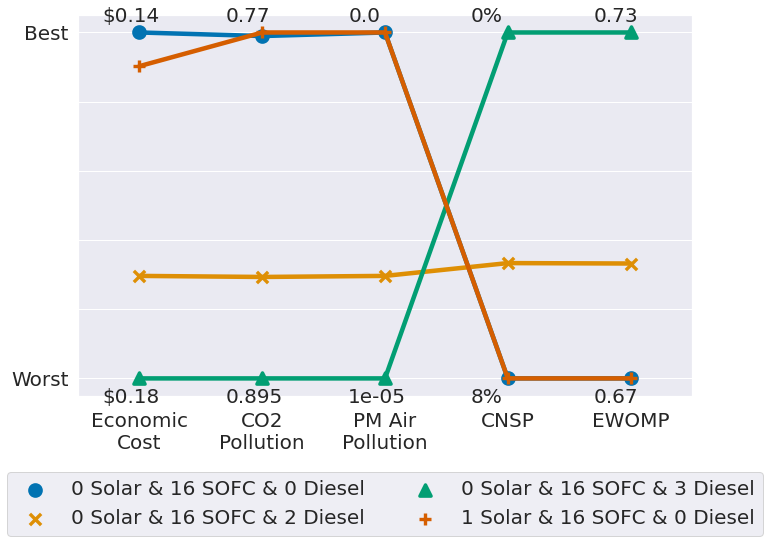

In [107]:
all_cases = ["510000RH0_large_winter_max_short"]

sb.set(font_scale=1.5)
create_normalized_nd_line_graph(
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs/Sensitivity\ Analysis/Budget"),
    plotfolder = Path("../../Part A/Images/NormalizedND"),
    no_sox_no2=True,
    font_size=20,
    axis_font_size=24,
    color_palette="colorblind",
    save_image=True
    )

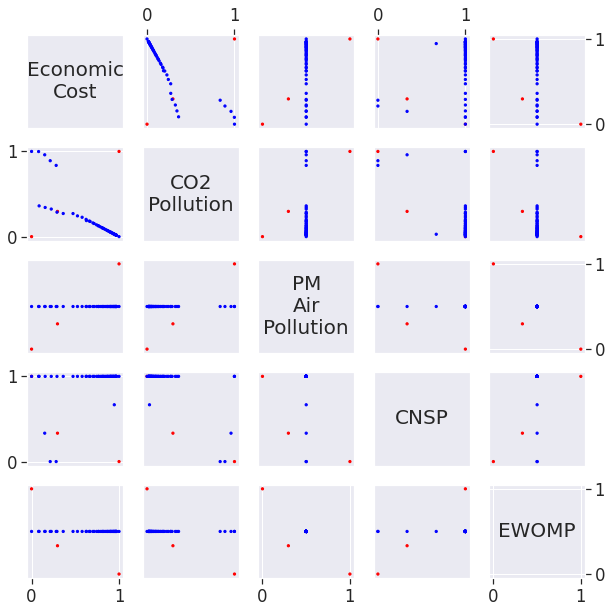

In [212]:
from importlib import reload
import scatterplot_matrix_creator
reload(scatterplot_matrix_creator)
from scatterplot_matrix_creator import scatterplot_matrix

no_sox_no2 = True
datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs")
plotfolder = Path("../../Part A/Images/ScatterplotMatrix")

data_to_plot = None

category_colors = {"ND RH0 in Winter": "red", "ALL RH0 in Winter": 'gray', "ND RH0 in Spring": "red", "ALL RH0 in Spring": 'gray', "ND RH0 in Summer": "red", "ALL RH0 in Summer": 'gray', "ND RH0 in Fall": "red", "ALL RH0 in Fall": 'gray',
"ND RH2 in Winter": "blue", "ALL RH2 in Winter": 'gray', "ND RH2 in Spring": "blue", "ALL RH2 in Spring": 'gray', "ND RH2 in Summer": "blue", "ALL RH2 in Summer": 'gray', "ND RH2 in Fall": "blue", "ALL RH2 in Fall": 'gray'}

RHs = ["RH0", "RH2"]
load_sets = ["large"]#, "large", "only", "small"]
seasons = ["winter"]#, "winter", "spring", "summer", "fall"]
loadtype = ["max"]
lengths = ["short"]#, "short", "long"]
groups = ["nd"]
all_cases = ["_".join([rh, ls, s, lo, le, g]) for rh, ls, s, lo, le, g in itertools.product(RHs, load_sets, seasons, loadtype, lengths, groups)]

case_titles = []

for case in all_cases:
    case_title = " ".join([case.split("_")[5].upper(), case.split("_")[0].upper(), "in", case.split("_")[2].capitalize()])
    case_titles.append(case_title)
    case_filepath = datafolder.joinpath(f"{case}.csv")
    case_data = read_csv(case_filepath, index_col=[0])
    if no_sox_no2:
        case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
    min_val = case_data.min()
    max_val = case_data.max()

    worst_val = min_val.copy()
    best_val = max_val.copy()

    # # Gotta switch the best and worst values for EWOMP, because we want distance from min, not distance from max ?????
    # temp_val = min_val["EWOMP"]
    # min_val["EWOMP"] = max_val["EWOMP"]
    # max_val["EWOMP"] = temp_val

    normalized_case_data=(max_val-case_data)/(max_val-min_val)
    normalized_case_data.fillna(0.5, inplace=True)
    normalized_case_data["Category"]=case_title
    if data_to_plot is None:
        data_to_plot = normalized_case_data
    else:
        data_to_plot = concat([data_to_plot,normalized_case_data], ignore_index=True)
        data_to_plot = data_to_plot.reset_index(drop=True)

fig = scatterplot_matrix(data_to_plot, category_colors=category_colors, s=5)
fig.savefig(plotfolder.joinpath(f'({load_sets[0]}) {" vs ".join(case_titles)}.pdf')) #saves plot as pdf

In [125]:
def compare_RHs_one_season(
    datafolder, plotfolder, no_sox_no2=False, font_size = 20, axis_font_size=20, marker_size=50, save_image=True,
    locs=["RH0", "RH2"], sizes=["large", "small"], season="winter", nd_season="winter", duration="short"):

    mpl.rcParams['font.size'] = str(font_size)
    mpl.rcParams['axes.labelsize'] = str(axis_font_size)
    mpl.rcParams['axes.titlesize'] = str(axis_font_size)
    mpl.rcParams['lines.markersize'] = str(marker_size)

    mks = itertools.cycle(['o', 'x', '^', '+', 'v', '8', '*', 's', 'p', 'd'])

    nd_indices = [None, None]
    if nd_season != season:
        nd_cases = ["_".join([locs[0], sizes[0], nd_season, "max", duration]), "_".join([locs[1], sizes[1], nd_season, "max", duration])]
        for idx, nd_case in enumerate(nd_cases):
            nd_case_filepath = datafolder.joinpath(f"{nd_case}_nd.csv")
            nd_case_data = read_csv(nd_case_filepath, index_col=[0])
            nd_indices[idx] = nd_case_data.index
    
    comparison_cases = ["_".join([locs[0], sizes[0], season, "max", duration]), "_".join([locs[1], sizes[1], season, "max", duration])]
    min_val = None
    max_val = None
    comparison_dfs = []
    for idx, case in enumerate(comparison_cases):
        if nd_indices[idx] is None:
            case_filepath = datafolder.joinpath(f"{case}_nd.csv")
            case_data = read_csv(case_filepath, index_col=[0])
        else:
            case_filepath = datafolder.joinpath(f"{case}_generated.csv")
            case_data = read_csv(case_filepath, index_col=[0])
            case_data = case_data.loc[[ind for ind in nd_indices[idx]]]
        if no_sox_no2:
            case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
        min_val = case_data.min() if min_val is None else min_val.combine(case_data.min(), min, 0)
        max_val = case_data.max() if max_val is None else max_val.combine(case_data.max(), max, 0)
        comparison_dfs.append(case_data)
    
    # case_data = concat(comparison_dfs[0], comparison_dfs[1])
    case0_data = comparison_dfs[0]
    case1_data = comparison_dfs[1]

    worst_val = min_val
    best_val = max_val

    normalized_case0_data=(max_val-case0_data)/(max_val-min_val)
    normalized_case0_data.fillna(0.5, inplace=True)
    melted_case0_data = normalized_case0_data.melt(ignore_index=False)
    melted_case0_data["Index"] = melted_case0_data.index

    normalized_case1_data=(max_val-case1_data)/(max_val-min_val)
    normalized_case1_data.fillna(0.5, inplace=True)
    melted_case1_data = normalized_case1_data.melt(ignore_index=False)
    melted_case1_data["Index"] = melted_case1_data.index
    
    # mean_case_data = case_data.mean(axis=1)
    plt.figure(figsize=(11,7))
    with plt.rc_context({'lines.linewidth': 2.5}):
        ax = sb.pointplot(data=melted_case0_data, x="variable", y="value", hue="Index", errorbar=None, markers=[next(mks) for i in melted_case0_data.index.unique()], palette="autumn")#, palette=keydefaultdict(default_factory=palette_color_for_series, all_hues=melted_case_data.index.values))
        dummy1, = plt.plot([0], marker='None',
                linestyle='None', label='RH0 Non-Dominated Options')
        plot1_collections = list(ax.collections).copy()
        sb.pointplot(data=melted_case1_data, x="variable", y="value", hue="Index", errorbar=None, markers=[next(mks) for i in melted_case1_data.index.unique()], palette="cool", ax=ax)
        dummy2, = plt.plot([0], marker='None',
                linestyle='None', label='RH2 Non-Dominated Options')
        plot2_collections = [collection for collection in ax.collections if collection not in plot1_collections]
        # plt.setp(ax.collections, sizes=[30])
    ax.set(xlabel=None, ylabel="Normalized Value")
    # plt.title(f"Non-Dominated Set Performance for {' & '.join([case.replace('_', ' ').title() for case in comparison_cases])}", fontsize=font_size, pad=20)
    ax.set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text(),9)) for ticklabel in ax.get_xticklabels()])
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.tick_params(axis='x', which='major', pad=10)
    # ax.xaxis.labelpad = 25
    plt.legend(
        [dummy1] + plot1_collections + [dummy2] + plot2_collections,
        ["RH0 Non-Dominated Options"] + [collection.get_label() for collection in plot1_collections] + ["RH2 Non-Dominated Options"] + [collection.get_label() for collection in plot2_collections],
        loc='upper center', bbox_to_anchor=(0.5, -0.2), borderaxespad=0, ncol=2)#, fontsize=font_size)

    best_annotations = []

    for idx, criterion in enumerate(case_data.columns):
        # if no_sox_no2 and (idx==2 or idx==4):
        #     continue
        annotation_formatter = annotation_text_formatter(criterion)
        hue_vals = []
        for collection in ax.collections:
            hue_vals.append([point for point in collection.get_offsets().data if point[0] == idx][0][1])
        worst_hue_val = max(hue_vals)
        worst_annotation = annotation_formatter(worst_val[criterion])
        best_hue_val = min(hue_vals)
        best_annotation = annotation_formatter(best_val[criterion])
        if worst_hue_val != best_hue_val:
            plt.annotate(worst_annotation, xy=(idx, worst_hue_val), xytext=(idx-0.3,worst_hue_val+0.01), annotation_clip=False)
        min_x_offset=0.3
        min_y_offset=0.05
        best_annotations.append(plt.annotate(best_annotation, xy=(idx, best_hue_val), xytext=(idx-min_x_offset,best_hue_val-min_y_offset), annotation_clip=False))

    # adjust_text(best_annotations, only_move = {'points':'x', 'text':'x', 'objects':'x'})#, force_text=(0.5,1.25))#
    if save_image:
        ax.figure.savefig(plotfolder.joinpath(f"{'_'.join(['_'.join([locs[0], sizes[0]]), '_'.join([locs[1], sizes[1]])])}_{nd_season}_nd_in_{season}_comparison.png"), bbox_inches = "tight")

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((1.0, 0.5019607843137255, 0.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((0.011764705882352941, 0.9882352941176471, 1.0)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((0.10980392156862745, 0.8901960784313725, 1.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py

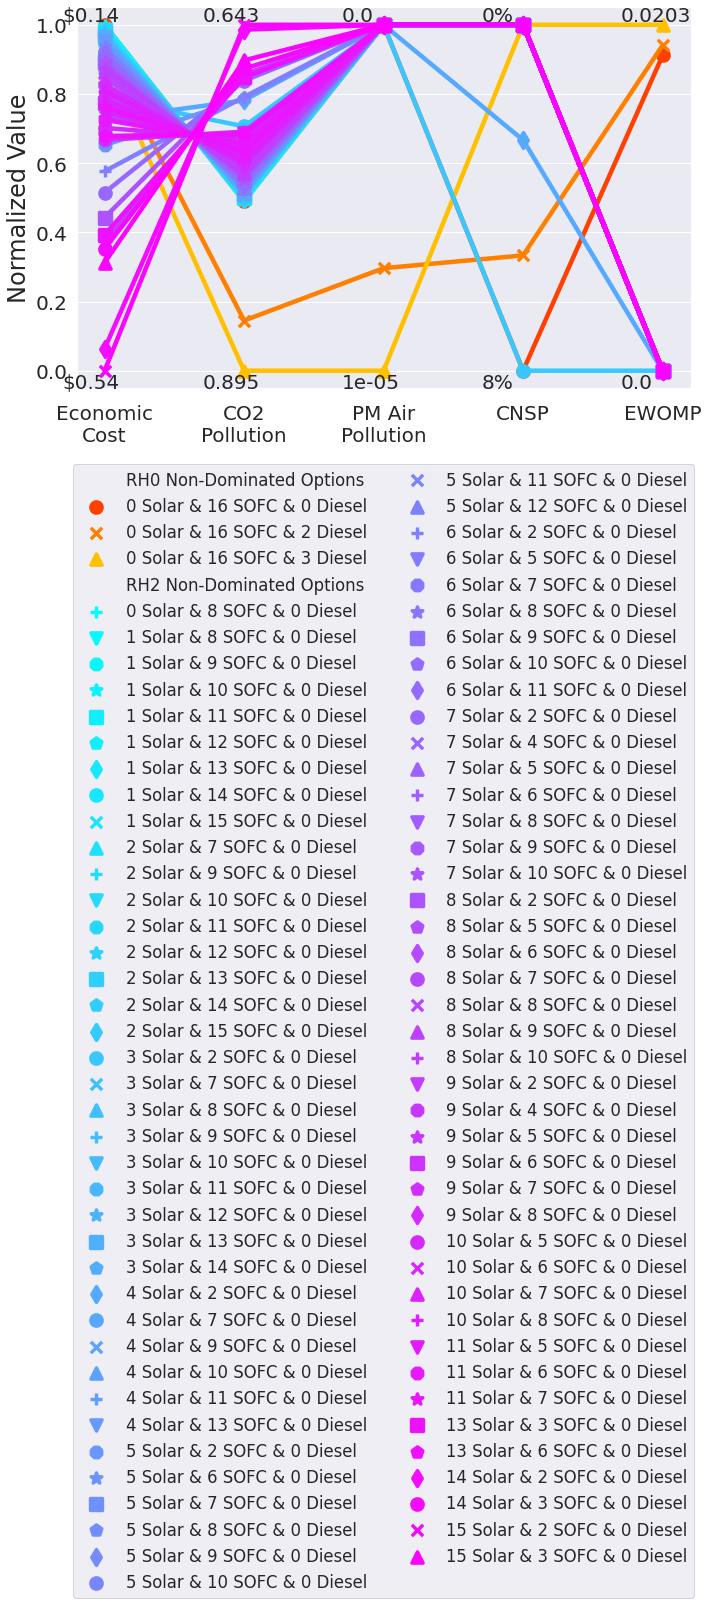

In [126]:
compare_RHs_one_season(
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
    plotfolder = Path("../../Part A/Images/NormalizedND"),
    no_sox_no2=True,
    font_size=20,
    axis_font_size=24,
    season="winter",
    nd_season="winter",
    # sizes=["large", "large"],
    save_image=False
    )

In [108]:
class weight_obj():
    def __init__(self, name, weights_dict):
        self.weights_dict = weights_dict
        self.name = name
    
    def get_weight(self, criterion):
        if criterion in self.weights_dict:
            return self.weights_dict[criterion]
        raise Exception(f"No weight was given for criterion {criterion}")
    
    def get_name(self):
        return self.name



In [82]:
def create_nd_seasonal_performance_line_graph(datafolder, plotfolder, length, system_type="generated", network="", nd_season="", color_palette="autumn", save_image=True, marker_size=50, no_sox_no2=False, weights=None):
    
    mpl.rcParams['lines.markersize'] = str(marker_size)
    for nd_season in seasons:

        

        nd_index = None
        nd_case = "_".join([network, nd_season, "max", length])
        nd_case_filepath = datafolder.joinpath(f"{nd_case}_nd.csv")
        nd_case_data = read_csv(nd_case_filepath, index_col=[0])
        nd_index = nd_case_data.index

        season_dfs = []
        min_val = None
        max_val = None
        for season in seasons:
            case = "_".join([network, season, "max", length])
            if season==nd_season:
                case_filepath = datafolder.joinpath(f"{case}_nd.csv")
            else:
                case_filepath = datafolder.joinpath(f"{case}_{system_type}.csv")
            case_data = read_csv(case_filepath, index_col=[0])
            if season != nd_season:
                case_data = case_data.loc[[ind for ind in nd_index]]
            if no_sox_no2:
                case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
            min_val = case_data.min() if min_val is None else min_val.combine(case_data.min(), min)
            max_val = case_data.max() if max_val is None else max_val.combine(case_data.max(), max)

            season_dfs.append(case_data)
        
        normalized_dfs = []
        for season_data in season_dfs:
            normalized_season_data=(max_val-season_data)/(max_val-min_val)
            normalized_season_data.fillna(0.5, inplace=True)
            if no_sox_no2:
                criteria_list = CRITERIA.copy()
                del criteria_list[4]
                del criteria_list[2]
            else:
                criteria_list = CRITERIA
            normalized_season_data["equal_weight_score"] = sum((normalized_season_data[criterion] * (weights.get_weight(criterion) if weights is not None else 1) for criterion in criteria_list))
            normalized_season_data["Index"] = normalized_season_data.index
            normalized_season_data = normalized_season_data[['Index', 'equal_weight_score']]
            normalized_dfs.append(normalized_season_data)
        
        merge_01 = merge(normalized_dfs[0], normalized_dfs[1], on='Index', how='inner', suffixes=(f"_{seasons[0]}", f"_{seasons[1]}"))
        merge_23 = merge(normalized_dfs[2], normalized_dfs[3], on='Index', how='inner', suffixes=(f"_{seasons[2]}", f"_{seasons[3]}"))
        merge_4 = merge(merge_01, merge_23, on="Index", how="inner", suffixes=(None,None))
        if len(merge_4) == 0:
            print("No systems are evaluated across all seasons")
            continue
        # merge_4.set_index("Index", inplace=True)
        melted_df = melt(merge_4, id_vars = ["Index"])
        # melted_df.set_index("Index", inplace=True)
        
        plt.figure(figsize=(11,7))
        mks = itertools.cycle(['o', 'x', '^', '+', 'v', '8', '*', 's', 'p', 'd'])
        
        with plt.rc_context({'lines.linewidth': 2.5}):
            ax = sb.pointplot(data=melted_df, x="variable", y="value", hue="Index", errorbar=None, palette=color_palette, markers=[next(mks) for i in melted_df.index.unique()])#keydefaultdict(default_factory=palette_color_for_series, all_hues=melted_df["Index"].values))
        ax.set(xlabel=None, ylabel="Equal Sum of Normalized Performance")
        # ax.set_ylim(bottom=0, top=1)
        plt.title(f"Equal-Weighted Performance for {network.replace('_', ' ').title()} For Seasonal Peak Loads", fontsize=20, pad=10)
        ax.set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text().split("_")[-1].title(), 9)) for ticklabel in ax.get_xticklabels()])
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), borderaxespad=0, ncol=2)
        if save_image:
            ax.figure.savefig(plotfolder.joinpath(f"{network}_max_{length}_{nd_season}_nd.png"), bbox_inches = "tight")

In [133]:
sb.set(font_scale=1.5)
rcParams['figure.facecolor'] = 'white'


equal_weight_obj = weight_obj("equal_weighting", {
    CRITERIA[0]:0.2,
    CRITERIA[1]:0.2,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.2,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.2,
    CRITERIA[6]:0.2
})

create_nd_seasonal_performance_line_graph(
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
    plotfolder = Path("../../Part A/Images/SeasonalPerformance"),
    length="short",
    system_type="generated",
    network="RH0_large",
    color_palette="autumn",
    no_sox_no2=True,
    save_image=False,
    weights=equal_weight_obj)

IndexError: list index out of range

In [83]:
seasons = ["winter", "spring", "summer", "fall"]

def compare_RHs_all_seasons(
    datafolder, plotfolder, no_sox_no2=False, font_size = 20, axis_font_size=20, marker_size=50, save_image=True, system_type="generated",
    networks=["RH0_large", "RH2_small"], nd_season="winter", duration="short", weights=None):
    
    mpl.rcParams['lines.markersize'] = str(marker_size)
    min_val = None
    max_val = None
    
    season_dfs = []

    
    nd_indices = [None, None]
    nd_cases = ["_".join([networks[0], nd_season, "max", duration]), "_".join([networks[1], nd_season, "max", duration])]
    for idx, nd_case in enumerate(nd_cases):
        nd_case_filepath = datafolder.joinpath(f"{nd_case}_nd.csv")
        nd_case_data = read_csv(nd_case_filepath, index_col=[0])
        nd_indices[idx] = nd_case_data.index

    for i in [0,1]:
        season_dfs.append([])
        for season in seasons:
            case = "_".join([networks[i], season, "max", duration])
            if season==nd_season:
                case_filepath = datafolder.joinpath(f"{case}_nd.csv")
                case_data = read_csv(case_filepath, index_col=[0])
            else:
                case_filepath = datafolder.joinpath(f"{case}_{system_type}.csv")
                case_data = read_csv(case_filepath, index_col=[0])
                case_data = case_data.loc[[ind for ind in nd_indices[i]]]
            
            if no_sox_no2:
                case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
            min_val = case_data.min() if min_val is None else min_val.combine(case_data.min(), min, 0)
            max_val = case_data.max() if max_val is None else max_val.combine(case_data.max(), max, 0)

            season_dfs[i].append(case_data)
        
    normalized_dfs = []
    melted_dfs = []
    for i in [0,1]:
        normalized_dfs.append([])
        melted_dfs.append([])
        for season_data in season_dfs[i]:
            normalized_season_data=(max_val-season_data)/(max_val-min_val)
            normalized_season_data.fillna(0.5, inplace=True)
            if no_sox_no2:
                criteria_list = CRITERIA.copy()
                del criteria_list[4]
                del criteria_list[2]
            else:
                criteria_list = CRITERIA
            normalized_season_data["weighted_score"] = sum((normalized_season_data[criterion] * (weights.get_weight(criterion) if weights is not None else 1) for criterion in criteria_list))
            normalized_season_data["Index"] = normalized_season_data.index
            normalized_season_data = normalized_season_data[['Index', 'weighted_score']]
            normalized_dfs[i].append(normalized_season_data)
        
        merge_01 = merge(normalized_dfs[i][0], normalized_dfs[i][1], on='Index', how='inner', suffixes=(f"_{seasons[0]}", f"_{seasons[1]}"))
        merge_23 = merge(normalized_dfs[i][2], normalized_dfs[i][3], on='Index', how='inner', suffixes=(f"_{seasons[2]}", f"_{seasons[3]}"))
        merge_4 = merge(merge_01, merge_23, on="Index", how="inner", suffixes=(None,None))
        if len(merge_4) == 0:
            print("No systems are evaluated across all seasons")
            continue
        # merge_4.set_index("Index", inplace=True)
        melted_dfs[i] = melt(merge_4, id_vars = ["Index"])
        # melted_df.set_index("Index", inplace=True)
    
    plt.figure(figsize=(11,7))
    mks = itertools.cycle(['o', 'x', '^', '+', 'v', '8', '*', 's', 'p', 'd'])
    
    with plt.rc_context({'lines.linewidth': 2.5}):
        
        ax = sb.pointplot(data=melted_dfs[0], x="variable", y="value", hue="Index", errorbar=None, palette="autumn", markers=[next(mks) for i in melted_dfs[0].index.unique()])#keydefaultdict(default_factory=palette_color_for_series, all_hues=melted_df["Index"].values))
        
        dummy1, = plt.plot([0], marker='None',
                linestyle='None', label='RH0 Non-Dominated Options')
        plot1_collections = list(ax.collections).copy()
        sb.pointplot(data=melted_dfs[1], x="variable", y="value", hue="Index", errorbar=None, palette="cool", markers=[next(mks) for i in melted_dfs[1].index.unique()])
        dummy2, = plt.plot([0], marker='None',
                linestyle='None', label='RH2 Non-Dominated Options')
        plot2_collections = [collection for collection in ax.collections if collection not in plot1_collections]
        
        
    ax.set(xlabel=None, ylabel="Weighted Sum of Normalized Performance")
    # plt.title(f"Equal-Weighted Performance for {' & '.join([case.replace('_', ' ').title() for case in networks])} {nd_season.title()} Non-Dominated Set For Seasonal Peak Loads", fontsize=20, pad=10)
    ax.set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text().split("_")[-1].title(), 9)) for ticklabel in ax.get_xticklabels()])
    plt.legend(

        [dummy1] + plot1_collections + [dummy2] + plot2_collections,
        ["RH0 Non-Dominated Options"] + [collection.get_label() for collection in plot1_collections] + ["RH2 Non-Dominated Options"] + [collection.get_label() for collection in plot2_collections],
        loc='upper center', bbox_to_anchor=(0.5, -0.1), borderaxespad=0, ncol=2)
    if save_image:
        ax.figure.savefig(plotfolder.joinpath(f"{'_'.join(networks)}_{nd_season}_comparison{('_' + weights.get_name()) if weights is not None else ''}.png"), bbox_inches = "tight")

In [109]:
equal_weight_obj = weight_obj("Equal_Weighting", {
    CRITERIA[0]:0.2,
    CRITERIA[1]:0.2,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.2,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.2,
    CRITERIA[6]:0.2
})

climate_change_obj = weight_obj("Climate_Change", {
    CRITERIA[0]:0.1,
    CRITERIA[1]:0.6,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.1,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.1,
    CRITERIA[6]:0.1
})

health_obj = weight_obj("Health", {
    CRITERIA[0]:0.1,
    CRITERIA[1]:0.1,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.6,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.1,
    CRITERIA[6]:0.1
})

outage_mitigation_obj = weight_obj("EWOMP_Weighting", {
    CRITERIA[0]:0.1,
    CRITERIA[1]:0.1,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.1,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.1,
    CRITERIA[6]:0.6
})

economical_outage_mitigation_obj = weight_obj("Economical_EWOMP_Weighting", {
    CRITERIA[0]:0.2,
    CRITERIA[1]:0.1,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.1,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.1,
    CRITERIA[6]:0.5
})

dependability_obj = weight_obj("Dependability_Weighting", {
    CRITERIA[0]:0.2,
    CRITERIA[1]:0.1,
    CRITERIA[2]:0, # Ignored
    CRITERIA[3]:0.1,
    CRITERIA[4]:0, # Ignored
    CRITERIA[5]:0.4,
    CRITERIA[6]:0.2
})



In [ ]:
# compare_RHs_all_seasons(
#     datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
#     plotfolder = Path("../../Part A/Images/SeasonalPerformance"),
#     no_sox_no2=True,
#     font_size=20,
#     axis_font_size=24,
#     weights=economical_outage_mitigation_obj,
#     save_image=True
#     )

In [110]:
seasons = ["winter", "spring", "summer", "fall"]

def compare_RH_all_seasons_different_weights(
    datafolder, plotfolder, no_sox_no2=False, font_size = 20, axis_font_size=20, marker_size=50, save_image=True, system_type="generated",
    network="510000RH0_large", nd_season="winter", duration="short", weights=None):
    
    mpl.rcParams['lines.markersize'] = str(marker_size)
    min_val = None
    max_val = None
    
    season_df = []

    
    nd_case = "_".join([network, nd_season, "max", duration])
    
    nd_case_filepath = datafolder.joinpath(f"{nd_case}_nd.csv")
    nd_case_data = read_csv(nd_case_filepath, index_col=[0])
    nd_index = nd_case_data.index

    
    for season in seasons:
        case = "_".join([network, season, "max", duration])
        if season==nd_season:
            case_filepath = datafolder.joinpath(f"{case}_nd.csv")
            case_data = read_csv(case_filepath, index_col=[0])
        else:
            case_filepath = datafolder.joinpath(f"{case}_{system_type}.csv")
            case_data = read_csv(case_filepath, index_col=[0])
            case_data = case_data.loc[[ind for ind in nd_index if ind in case_data.index]]
        
        if no_sox_no2:
            case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
        min_val = case_data.min() if min_val is None else min_val.combine(case_data.min(), min, 0)
        max_val = case_data.max() if max_val is None else max_val.combine(case_data.max(), max, 0)

        season_df.append(case_data)
        
    normalized_dfs = []
    melted_dfs = []
    for i in [0,1]:
        normalized_dfs.append([])
        melted_dfs.append([])
        
        for season_data in season_df:
            normalized_season_data=(max_val-season_data)/(max_val-min_val)
            normalized_season_data.fillna(0.5, inplace=True)
            if no_sox_no2:
                criteria_list = CRITERIA.copy()
                del criteria_list[4]
                del criteria_list[2]
            else:
                criteria_list = CRITERIA
            normalized_season_data["weighted_score"] = sum((normalized_season_data[criterion] * (weights[i].get_weight(criterion) if weights is not None and weights[i] is not None else 1) for criterion in criteria_list))
            normalized_season_data["Index"] = normalized_season_data.index
            normalized_season_data = normalized_season_data[['Index', 'weighted_score']]
            normalized_dfs[i].append(normalized_season_data)
        
        merge_01 = merge(normalized_dfs[i][0], normalized_dfs[i][1], on='Index', how='inner', suffixes=(f"_{seasons[0]}", f"_{seasons[1]}"))
        merge_23 = merge(normalized_dfs[i][2], normalized_dfs[i][3], on='Index', how='inner', suffixes=(f"_{seasons[2]}", f"_{seasons[3]}"))
        merge_4 = merge(merge_01, merge_23, on="Index", how="inner", suffixes=(None,None))
        if len(merge_4) == 0:
            print("No systems are evaluated across all seasons")
            continue
        # merge_4.set_index("Index", inplace=True)
        melted_dfs[i] = melt(merge_4, id_vars = ["Index"])
        # melted_df.set_index("Index", inplace=True)
    
    plt.figure(figsize=(11,7))
    mks = itertools.cycle(['o', 'x', '^', '+', 'v', '8', '*', 's', 'p', 'd'][:len(merge_4)])
    
    with plt.rc_context({'lines.linewidth': 2.5}):
        
        ax = sb.pointplot(data=melted_dfs[0], x="variable", y="value", hue="Index", errorbar=None, palette="colorblind", linestyles="-", markers=[next(mks) for i in melted_dfs[0].index.unique()])#keydefaultdict(default_factory=palette_color_for_series, all_hues=melted_df["Index"].values))
        
        dummy1, = plt.plot([0], marker='None',
                color="black", linestyle='-', label=weights[0].get_name().replace('_',' ').title())
        dummy1a, = plt.plot([0], marker='None',
                linestyle='None', label="$w_{eq}=[0.2,0.2,0.2,0.2,0.2]$")
        plot1_collections = list(ax.collections).copy()
        # plot1_collections[0].set_linestyle("--")
        sb.pointplot(data=melted_dfs[1], x="variable", y="value", hue="Index", errorbar=None, palette="colorblind", linestyles=":", markers=[next(mks) for i in melted_dfs[1].index.unique()])
        dummy2, = plt.plot([0], marker='None',
                color="black", linestyle=":", label=weights[1].get_name().replace('_',' ').title())
        dummy2a, = plt.plot([0], marker='None',
                linestyle="None", label="$w_{om}=[0.2,0.1,0.1,0.1,0.5]$")
        plot2_collections = [collection for collection in ax.collections if collection not in plot1_collections]
        # plot2_collections[0].set_linestyle(":")
        
        
    ax.set_xlabel(None)
    # ax.set_ylabel(None)
    # ax.set_yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=["Worst", "", "", "", "", "Best"])#, minor=True)
    ax.set_ylabel("Weighted Sum of Normalized Performance", fontsize = axis_font_size)
    # plt.title(f"Equal-Weighted Performance for {' & '.join([case.replace('_', ' ').title() for case in networks])} {nd_season.title()} Non-Dominated Set For Seasonal Peak Loads", fontsize=20, pad=10)
    ax.set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text().split("_")[-1].title(), 9)) for ticklabel in ax.get_xticklabels()], fontsize=font_size)
    plt.yticks(fontsize=font_size)
    
    # Original legend
    # plt.legend(
    #     [dummy1, dummy1a] + plot1_collections + [dummy2, dummy2a] + plot2_collections,
    #     [weights[0].get_name().replace('_',' ').title(), "$w_{eq}=[0.2,0.2,0.2,0.2,0.2]$"] + [collection.get_label() for collection in plot1_collections] + [weights[1].get_name().replace('_',' ').title(), "$w_{om}=[0.2,0.1,0.1,0.1,0.5]$"] + [collection.get_label() for collection in plot2_collections],
    #     loc='upper center', bbox_to_anchor=(0.5, -0.1), borderaxespad=0, ncol=2)

    # New legend concept
    first_legend = plt.legend(
        [dummy1, dummy1a, dummy2, dummy2a],
        [weights[0].get_name().replace('_',' '), "$w_{eq}=[0.2,0.2,0.2,0.2,0.2]$", weights[1].get_name().replace('_',' '), "$w_{om}=[0.2,0.1,0.1,0.1,0.5]$"],
        loc='upper center', bbox_to_anchor=(0.5, -0.3), borderaxespad=0, ncol=2, fontsize=font_size)
    ax.add_artist(first_legend)
    plt.legend(
        plot1_collections + plot2_collections,
        [collection.get_label() for collection in plot1_collections],
        loc='upper center', bbox_to_anchor=(0.5, -0.1), borderaxespad=0, ncol=2, fontsize=font_size)

    
    if save_image:
        ax.figure.savefig(plotfolder.joinpath(f"{network}_{nd_season}_comparison{''.join((('_' + weight.get_name()) if weight is not None else '') for weight in weights if weights is not None)}.svg"), bbox_inches = "tight")

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((0.8705882352941177, 0.5607843137254902, 0.0196078431372549)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((0.8352941176470589, 0.3686274509803922, 0.0)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning:

You passed a edgecolor/edgecolors ((0.8705882352941177, 0.5607843137254902, 0.0196078431372549)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/home/arnavgautam/venv/lib/pyth

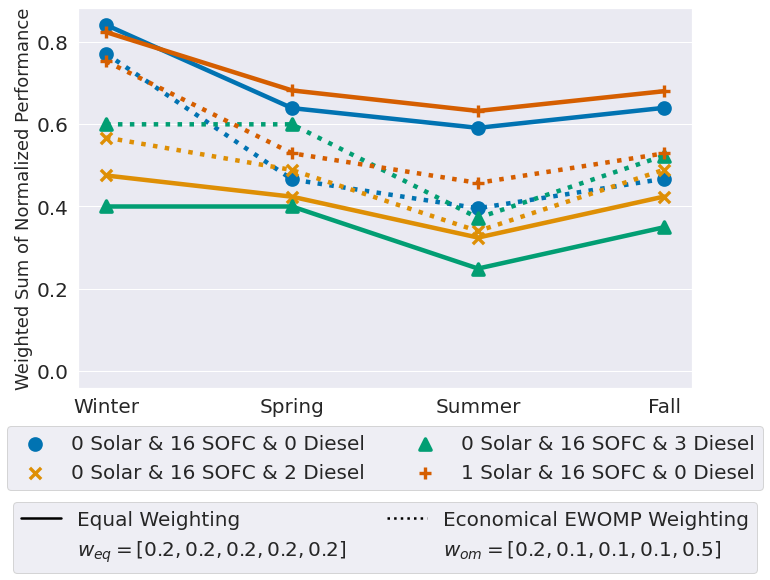

In [111]:
compare_RH_all_seasons_different_weights(
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs/Sensitivity\ Analysis/Budget"),
    plotfolder = Path("../../Part A/Images/SeasonalPerformance"),
    no_sox_no2=True,
    font_size=20,
    axis_font_size=18,
    weights=[equal_weight_obj, economical_outage_mitigation_obj],
    nd_season="winter",
    save_image=True
    )

In [92]:
## SENSITIVITY ANALYSIS ##

Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "file:///mnt/c/Users/Arnav/Documents/Research/resilience_hub_MC ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 
Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "file:///mnt/c/Users/Arnav/Documents/Research/resilience_hub_MC ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 
Start : This command cannot be run due to the error: The system cannot f

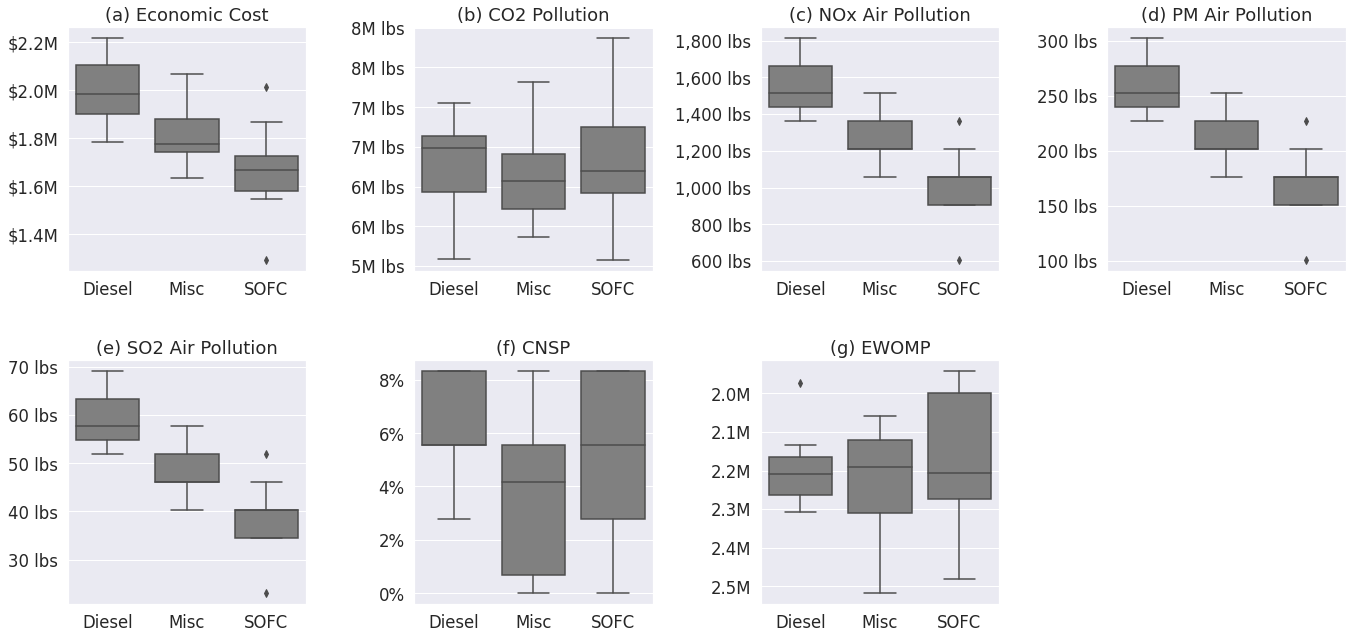

In [25]:
sb.set_theme(font_scale=1.5)

rcParams['figure.facecolor'] = 'white'
create_box_and_whisker(
    network = "RH0_large",
    length="short",
    include = [True, True, True, True, True, True, True],
    winter_loadtype="max", 
    figsize=(20,10),
    pad=3,
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs/Sensitivity Analysis/SOFC cost/38595"),
    plotfolder = Path("../../Part A/Images/BoxAndWhiskers/Sensitivity Analysis/SOFC cost/38595"),
    props={'boxprops':{'facecolor':'gray'}},
    system_set="nd",
    save_file=False)

In [251]:
def sensitivity_analysis_tech_breakdown(datafolder, network="RH0_large", winter_loadtype="max", length="short", sensitivity_points=[], system_set="nd", percent_tech = "SOFC", save_file=True):
    retval = dict()
    for sensitivity_point in sensitivity_points:
        datasubfolder = datafolder.joinpath(sensitivity_point)
        all_case_data = None
        for season in seasons:
            case = "_".join([network, season, winter_loadtype if season == "winter" else "max", length])
            case_filepath = datasubfolder.joinpath(f"{case}_{system_set}.csv")
            case_data = read_csv(case_filepath, index_col=[0])
            case_data = concat([case_data, case_data.apply(lambda row: assign_tech_numbers(row.name), axis = "columns", result_type = "expand")], axis='columns')
            all_case_data = case_data if all_case_data is None else concat([all_case_data, case_data]) if (case_data is not None and len(case_data) != 0) else all_case_data
        if all_case_data is None:
            continue
        all_case_data["Bucket"] = all_case_data.aggregate(get_row_bucket, axis = 1)
        all_case_data_groupby = all_case_data.groupby("Bucket")
        bucket_balance = defaultdict(lambda: 0)
        for bucket_name, bucketed_data in all_case_data_groupby:
            bucket_balance[bucket_name] = bucketed_data.shape[0]
        
            print(bucket_name)
            pprint(bucketed_data.shape)
            
        all_case_data["Solar kW"] = all_case_data["Solar"] * 3.8
        all_case_data["SOFC kW"] = all_case_data["SOFC"] * 10
        all_case_data["Diesel kW"] = all_case_data["Diesel"] * 10
        breakdown_data = all_case_data[["Solar kW", "SOFC kW", "Diesel kW"]]
        breakdown_data["Total kW"] = sum([all_case_data["Solar kW"], all_case_data["SOFC kW"], all_case_data["Diesel kW"]])
        breakdown_data[f"{percent_tech}_percent"] = breakdown_data[f"{percent_tech} kW"] / breakdown_data["Total kW"]
        tech_percent = breakdown_data.mean(axis=0)[f"{percent_tech}_percent"]
        print(f"\nOverall {percent_tech} Percentage\n")
        print(tech_percent)

        retval[sensitivity_point] = (all_case_data[["Economic Cost", "CO2 Pollution", "PM Air Pollution", "CNSP", "EWOMP"]], tech_percent, bucket_balance)
    # retval = retval[["Economic Cost", "CO2 Pollution", "PM Air Pollution", "CNSP", "EWOMP"]]
    return retval


In [252]:
SOFC_percent_sensitivity_to_cost_data = sensitivity_analysis_tech_breakdown(
    network = "RH0_large",
    length="short",
    winter_loadtype="max", 
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs/Sensitivity Analysis/SOFC cost/"),
    sensitivity_points = ["30000", "35491", "38595", "46857", "68068"],
    percent_tech="SOFC",
    system_set="nd",
    save_file=False)

Diesel
(1, 11)
Misc
(1, 11)
SOFC
(18, 11)

Overall SOFC Percentage

0.6980349260832323
Diesel
(3, 11)
Misc
(11, 11)
SOFC
(13, 11)

Overall SOFC Percentage

0.5159563982579196


/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6

Diesel
(7, 11)
Misc
(10, 11)
SOFC
(13, 11)

Overall SOFC Percentage

0.43401545791549034


/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Diesel
(27, 11)
Misc
(1, 11)
SOFC
(4, 11)

Overall SOFC Percentage

0.2871811858390414


/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Diesel
(21, 11)

Overall SOFC Percentage

0.10086813944596769


/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [235]:
def graph_tech_percent_sensitivity(every_case_data, sensitivity_var, sensitivity_points=None, percent_tech = "SOFC", no_sox_no2=True, weights=None, y1lim_val=(0,0.75), y2lim_val=(0,3)):
    plt.rcParams['xtick.bottom'] = True
    performance_graph_data = DataFrame(columns=[sensitivity_var, "Equal Weighted Score"])
    performance_graph_data.set_index(sensitivity_var, inplace=True, drop=True)

    percentage_graph_data = DataFrame(columns=[sensitivity_var, f"% {percent_tech}"])
    percentage_graph_data.set_index(sensitivity_var, inplace=True, drop=True)
    # try:
    #     case_data.drop(columns=["Name", "Bucket"], inplace=True)
    # except:
    #     pass
    # if no_sox_no2:
    #     try:
    #         case_data.drop(columns=[CRITERIA[2],CRITERIA[4]], inplace=True)
    #     except:
    #         pass
    min_val = None
    max_val = None

    for price_point, (case_data, tech_Percent, bucket_balance) in every_case_data.items():
    
        min_val = case_data.min() if min_val is None else min_val.combine(case_data.min(), min, 0)
        max_val = case_data.max() if max_val is None else max_val.combine(case_data.max(), max, 0)

    # worst_val = min_val.copy()
    # best_val = max_val.copy()

    # # Gotta switch the best and worst values for EWOMP, because we want distance from min, not distance from max ?????
    # temp_val = min_val["EWOMP"]
    # min_val["EWOMP"] = max_val["EWOMP"]
    # max_val["EWOMP"] = temp_val
    

    for price_point, (case_data, tech_Percent, bucket_balance) in every_case_data.items():

        normalized_case_data=(max_val-case_data)/(max_val-min_val)
        normalized_case_data.fillna(0, inplace=True)
        normalized_case_data["equal_weight_score"] = sum([normalized_case_data["Economic Cost"], normalized_case_data["CO2 Pollution"], normalized_case_data["PM Air Pollution"], normalized_case_data["CNSP"], normalized_case_data["EWOMP"]])
            
        # normalized_case_data["Average Performance"] = normalized_case_data.mean(axis=0)["equal_weight_score"]

        performance_graph_data.loc[float(price_point)] = normalized_case_data.mean(axis=0)["equal_weight_score"]
        percentage_graph_data.loc[float(price_point)] = tech_Percent

        # melted_case_data = normalized_case_data.melt(ignore_index=False)
        # melted_case_data["Index"] = melted_case_data.index
    
    plt.figure(figsize=(7,7))
    ax1 = sb.pointplot(data=percentage_graph_data, x=percentage_graph_data.index, y=f"% {percent_tech}", errorbar=None, markers="o", color='green')#palette=sb.color_palette("blend:green,green", n_colors=1)) # sb.barplot(data=percentage_graph_data, x=percentage_graph_data.index, y="% SOFC"
    ax1.spines['left'].set_color('green') # ax1.axes_style(style={'axes.edgecolor': 'green', 'axes.labelcolor': 'green'})
    ax1.tick_params(axis='y', colors='green')
    ax1.yaxis.label.set_color('green')
    ax1.set_ylim(y1lim_val)
    
    plt.setp(ax1.collections, clip_on=False)
    plt.setp(ax1.lines, clip_on=False)
    
    plt.grid(False)
    
    ax2 = ax1.twinx()
    sb.pointplot(data=performance_graph_data, x=performance_graph_data.index, y="Equal Weighted Score", errorbar=None, markers="o", ax=ax2)
    ax2.set_ylim(y2lim_val)
    sensitivity_points is not None and ax1.set_xticklabels(labels=["$150,000", "$250,000", "$500,000", "$1,000,000"], rotation=0)
    # ax2.set_xticklabels(labels=["$30,000", "$35,491", "$38,595", "$46,857", "$68,068"], rotation=180)
    ax2.spines['right'].set_color('blue') # (style={'axes.edgecolor': 'blue', 'axes.labelcolor': 'blue'})
    ax2.tick_params(axis='y', colors='blue')
    ax2.yaxis.label.set_color('blue')
    
    plt.setp(ax2.collections, clip_on=False)
    plt.setp(ax2.lines, clip_on=False)
    plt.grid(False)

    ax1.spines['bottom'].set(alpha=0)
    

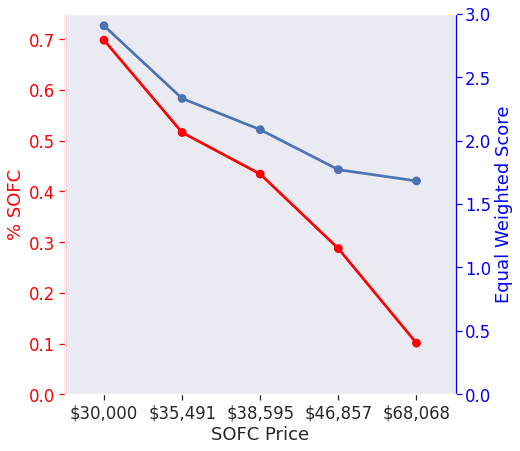

In [176]:
graph_tech_percent_sensitivity(SOFC_percent_sensitivity_to_cost_data)

Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "file:///mnt/c/Users/Arnav/Documents/Research/resilience_hub_MC ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 
Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "file:///mnt/c/Users/Arnav/Documents/Research/resilience_hub_MC ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 
Start : This command cannot be run due to the error: The system cannot f

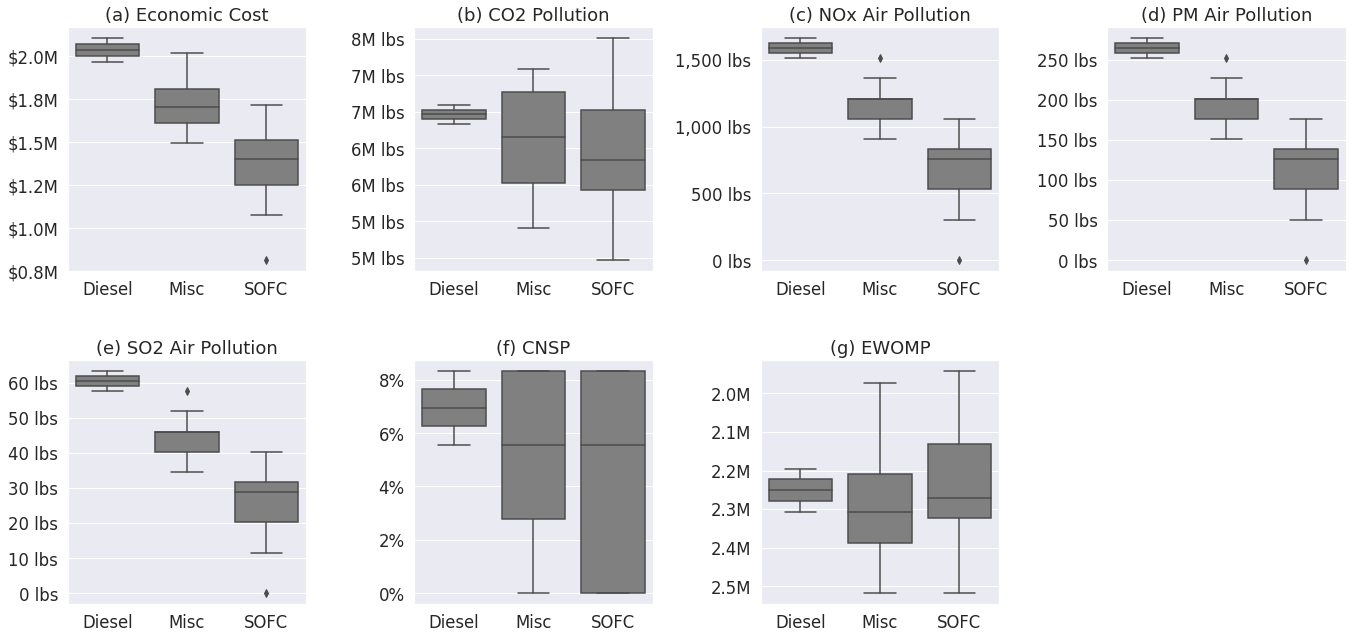

In [166]:
sb.set_theme(font_scale=1.5)

rcParams['figure.facecolor'] = 'white'
create_box_and_whisker(
    network = "RH0_large",
    length="short",
    include = [True, True, True, True, True, True, True],
    winter_loadtype="max", 
    figsize=(20,10),
    pad=3,
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs/Sensitivity Analysis/SOFC CO2 intensity/0.862007"),
    plotfolder = Path("../../Part A/Images/BoxAndWhiskers/Sensitivity Analysis/SOFC CO2 intensity/0.862007"),
    props={'boxprops':{'facecolor':'gray'}},
    system_set="nd",
    save_file=True)
    

In [253]:
SOFC_percent_sensitivity_to_co2_intensity_data = sensitivity_analysis_tech_breakdown(
    network = "RH0_large",
    length="short",
    winter_loadtype="max", 
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs/Sensitivity Analysis/SOFC CO2 intensity/"),
    sensitivity_points = ["0.5727", "0.771618", "0.862007"],
    system_set="nd",
    percent_tech="SOFC",
    save_file=False)

SOFC
(18, 11)

Overall SOFC Percentage

0.7389113046356219


/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Diesel
(1, 11)
Misc
(1, 11)
SOFC
(18, 11)

Overall SOFC Percentage

0.6980349260832323


/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Diesel
(2, 11)
Misc
(13, 11)
SOFC
(27, 11)

Overall SOFC Percentage

0.5718550106301314


/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



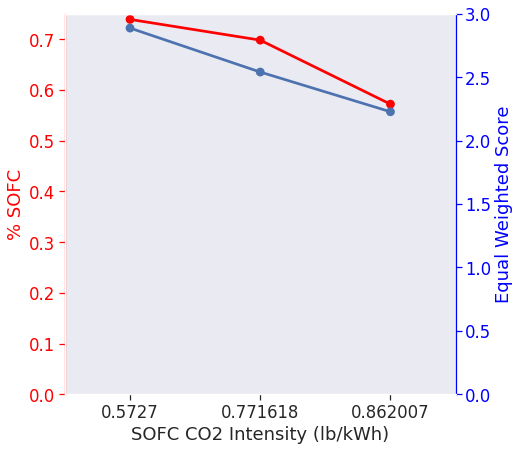

In [174]:
graph_tech_percent_sensitivity(SOFC_percent_sensitivity_to_co2_intensity_data)

In [178]:
def graph_equal_weight_score_sensitivity(every_case_data, sensitivity_var, no_sox_no2=True):
    plt.rcParams['xtick.bottom'] = True
    performance_graph_data = DataFrame(columns=[sensitivity_var, "Equal Weighted Score"])
    performance_graph_data.set_index(sensitivity_var, inplace=True, drop=True)
    min_val = None
    max_val = None

    for sensitivity_var_value, (case_data, SOFC_Percent), bucket_balance in every_case_data.items():
    
        min_val = case_data.min() if min_val is None else min_val.combine(case_data.min(), min, 0)
        max_val = case_data.max() if max_val is None else max_val.combine(case_data.max(), max, 0)
    
    for sensitivity_var_value, (case_data, SOFC_Percent), bucket_balance in every_case_data.items():

        normalized_case_data=(max_val-case_data)/(max_val-min_val)
        normalized_case_data.fillna(0, inplace=True)
        normalized_case_data["equal_weight_score"] = sum([normalized_case_data["Economic Cost"], normalized_case_data["CO2 Pollution"], normalized_case_data["PM Air Pollution"], normalized_case_data["CNSP"], normalized_case_data["EWOMP"]])
            
        performance_graph_data.loc[float(sensitivity_var_value)] = normalized_case_data.mean(axis=0)["equal_weight_score"]
    
    plt.figure(figsize=(7,7))
    ax1 = sb.pointplot(data=performance_graph_data, x=performance_graph_data.index, y="Equal Weighted Score", errorbar=None, markers="o")
    ax1.set_ylim(0,3)
    ax1.spines['left'].set_color('red') # ax1.axes_style(style={'axes.edgecolor': 'red', 'axes.labelcolor': 'red'})
    ax1.tick_params(axis='y', colors='red')
    ax1.yaxis.label.set_color('red')
    
    ax1.set_xticklabels(labels=["$150,000", "$250,000", "$500,000", "1,000,000"], rotation=90)
    
    plt.grid(False)

In [260]:
diesel_sensitivity_to_upfront_cost_data = sensitivity_analysis_tech_breakdown(
    network = "RH0_large",
    length="short",
    winter_loadtype="max", 
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs/Sensitivity Analysis/upfront cost/"),
    sensitivity_points = ["150000", "250000", "500000", "1000000"],
    system_set="nd",
    percent_tech = "Diesel",
    save_file=True)

Diesel
(4, 11)

Overall Diesel Percentage

0.8355569140774838
Diesel
(14, 11)

Overall Diesel Percentage

0.693668383022219


/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6

Diesel
(1, 11)
Misc
(1, 11)
SOFC
(18, 11)

Overall Diesel Percentage

0.23973591989075924


/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



SOFC
(82, 11)
Solar
(2, 11)

Overall Diesel Percentage

0.0


/tmp/ipykernel_6831/2856506267.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6831/2856506267.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



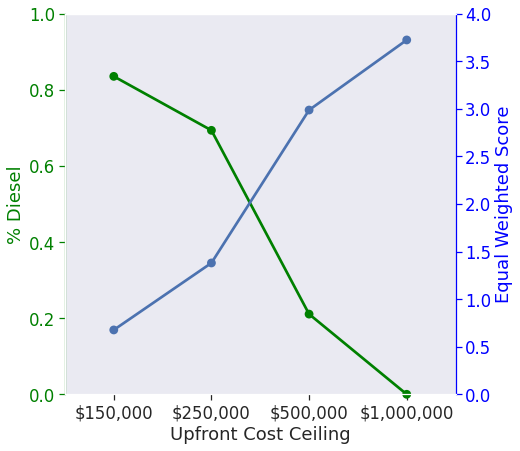

In [220]:
graph_tech_percent_sensitivity(diesel_sensitivity_to_upfront_cost_data, sensitivity_var = "Upfront Cost Ceiling", percent_tech="Diesel", sensitivity_points = ["150000", "250000", "500000", "1000000"], y1lim_val=(0,1), y2lim_val=(0,4))

In [256]:
bucket_breakdown_df = DataFrame(columns=["SOFC Cost", "# in Diesel", "# in Misc", "# in SOFC"])
bucket_breakdown_df.set_index("SOFC Cost", inplace=True)
for sensitivity_var_value, (case_data, tech_Percent, bucket_balance) in SOFC_percent_sensitivity_to_cost_data.items():
    bucket_breakdown_df.loc[sensitivity_var_value] = [bucket_balance["Diesel"], bucket_balance["Misc"], bucket_balance["SOFC"]]

print(bucket_breakdown_df)

           # in Diesel  # in Misc  # in SOFC
SOFC Cost                                   
30000                1          1         18
35491                3         11         13
38595                7         10         13
46857               27          1          4
68068               21          0          0


In [257]:
bucket_breakdown_df = DataFrame(columns=["SOFC CO2 Intensity", "# in Diesel", "# in Misc", "# in SOFC"])
bucket_breakdown_df.set_index("SOFC CO2 Intensity", inplace=True)
for sensitivity_var_value, (case_data, tech_Percent, bucket_balance) in SOFC_percent_sensitivity_to_co2_intensity_data.items():
    bucket_breakdown_df.loc[sensitivity_var_value] = [bucket_balance["Diesel"], bucket_balance["Misc"], bucket_balance["SOFC"]]

print(bucket_breakdown_df)

                    # in Diesel  # in Misc  # in SOFC
SOFC CO2 Intensity                                   
0.5727                        0          0         18
0.771618                      1          1         18
0.862007                      2         13         27


In [261]:
bucket_breakdown_df = DataFrame(columns=["Upfront Cost Ceiling", "# in Diesel", "# in Misc", "# in SOFC"])
bucket_breakdown_df.set_index("Upfront Cost Ceiling", inplace=True)
for sensitivity_var_value, (case_data, tech_Percent, bucket_balance) in diesel_sensitivity_to_upfront_cost_data.items():
    bucket_breakdown_df.loc[sensitivity_var_value] = [bucket_balance["Diesel"], bucket_balance["Misc"], bucket_balance["SOFC"]]

print(bucket_breakdown_df)

                      # in Diesel  # in Misc  # in SOFC
Upfront Cost Ceiling                                   
150000                          4          0          0
250000                         14          0          0
500000                          1          1         18
1000000                         0          0         82


In [65]:
def bucket_by_system_size(network, length, datafolder, season, system_set, save_file=False):
    case = "_".join([network, season, "max", length])
    case_filepath = datafolder.joinpath(f"{case}_{system_set}.csv")
    case_data = read_csv(case_filepath, index_col=[0])
    case_data = concat([case_data, case_data.apply(lambda row: assign_system_size_numbers(row.name), axis = "columns", result_type = "expand")], axis='columns')

    # print(f"smallest size is {case_data.min(axis=0)}")
    # print(f"largest size is {case_data.max(axis=0)}")

    # Split into quantiles

    case_data["System Size"] = qcut(case_data["System Size"], q=4)
    

    case_data_groupby = case_data.groupby("System Size")


    stacked_bar_chart_data = DataFrame()
    for bucket_name, bucketed_data in case_data_groupby:
        bucket_average = bucketed_data.mean()
        stacked_bar_chart_data = stacked_bar_chart_data.append({
            'System Size (kW)': bucket_name,
            'Solar Percent': bucket_average["Solar Percent"],
            'SOFC Percent': bucket_average["SOFC Percent"],
            'Diesel Percent': bucket_average["Diesel Percent"]
        }, ignore_index=True)
    
    stacked_bar_chart_data.set_index('System Size (kW)', drop=True, inplace=True)

    stacked_bar_chart_data.plot(kind="bar", stacked=True)
        

In [66]:
def assign_system_size_numbers(row_name):
    new_cols = dict()
    tech_numbers = row_name.split(" & ")
    solar_size = int(tech_numbers[0].split(" ")[0]) * 3.8
    sofc_size = int(tech_numbers[1].split(" ")[0]) * 10
    diesel_size = int(tech_numbers[2].split(" ")[0]) * 10
    system_size = solar_size + sofc_size + diesel_size
    new_cols["System Size"] = system_size
    new_cols["Solar Percent"] = solar_size / system_size
    new_cols["SOFC Percent"] = sofc_size / system_size
    new_cols["Diesel Percent"] = diesel_size / system_size
    return new_cols


/tmp/ipykernel_210/1581546471.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bucket_average = bucketed_data.mean()
/tmp/ipykernel_210/1581546471.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stacked_bar_chart_data = stacked_bar_chart_data.append({
/tmp/ipykernel_210/1581546471.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bucket_average = bucketed_data.mean()
/tmp/ipykernel_210/1581546471.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stacked_bar_chart

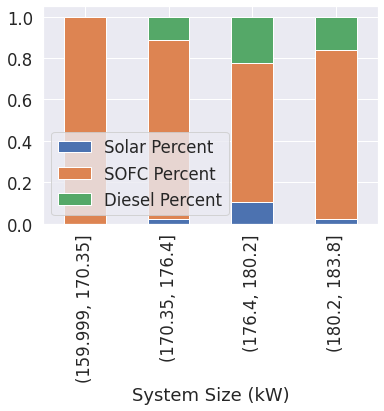

In [67]:
bucket_by_system_size_graph = bucket_by_system_size(
    network = "RH0_large",
    length="short",
    season="winter", 
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
    system_set="nd",
    save_file=False)

In [68]:
def create_box_and_whisker_no_buckets(datafolder, plotfolder, pad=3, figsize=(25,10), include=[True]*len(CRITERIA), network="all_branches", length="short", props={}, system_set="all", save_file=True):
    all_case_data = None
    for season in seasons:
        case = "_".join([network, season, "max", length])
        case_filepath = datafolder.joinpath(f"{case}_{system_set}.csv")
        case_data = read_csv(case_filepath, index_col=[0])
        case_data = concat([case_data, case_data.apply(lambda row: assign_tech_numbers(row.name), axis = "columns", result_type = "expand")], axis='columns')
        all_case_data = case_data if all_case_data is None else concat([all_case_data, case_data])
    # print(all_case_data.head())
    included_criteria = np.array(CRITERIA)[include]
    fig, axs = plt.subplots(2, ceil(len(included_criteria) / 2), figsize=figsize)
    axs = axs.reshape(1, ceil(len(included_criteria) / 2) * 2)[0]
    fig.tight_layout(pad=pad)
    # fig.suptitle(f"{network.replace('_', ' ').title()}, {'72 Hour' if length=='long' else '36 Hour'} Outage Duration, All Systems, Bucketed By Majority Technology", fontsize=20, y=1)
    formatter_lambda = lambda crit: FuncFormatter(lambda y_val, tick_pos: category_datapoint_label_formatter(crit)(y_val))
    for idx, criterion in enumerate(included_criteria):
        sb.boxplot(data=all_case_data, x=None, y=criterion, ax=axs[idx], **props).set(title=f"({ascii_lowercase[idx]}) {criterion}")
        # axs[idx].set_xticklabels(['\n'.join(textwrap.wrap(ticklabel.get_text(),9)) for ticklabel in axs[idx].get_xticklabels()], rotation=90)
        axs[idx].set(xlabel=None)
        axs[idx].set(ylabel=None)
        axs[idx].yaxis.set_major_formatter(formatter_lambda(criterion))
        # axs[idx].set_ylim(bottom=0)
        # pass
    for ax in axs[len(CRITERIA):]:
        fig.delaxes(ax)
    if save_file:
        fig.savefig(plotfolder.joinpath(f"{network}_{length}_{system_set}_no_buckets.png"))
    pass

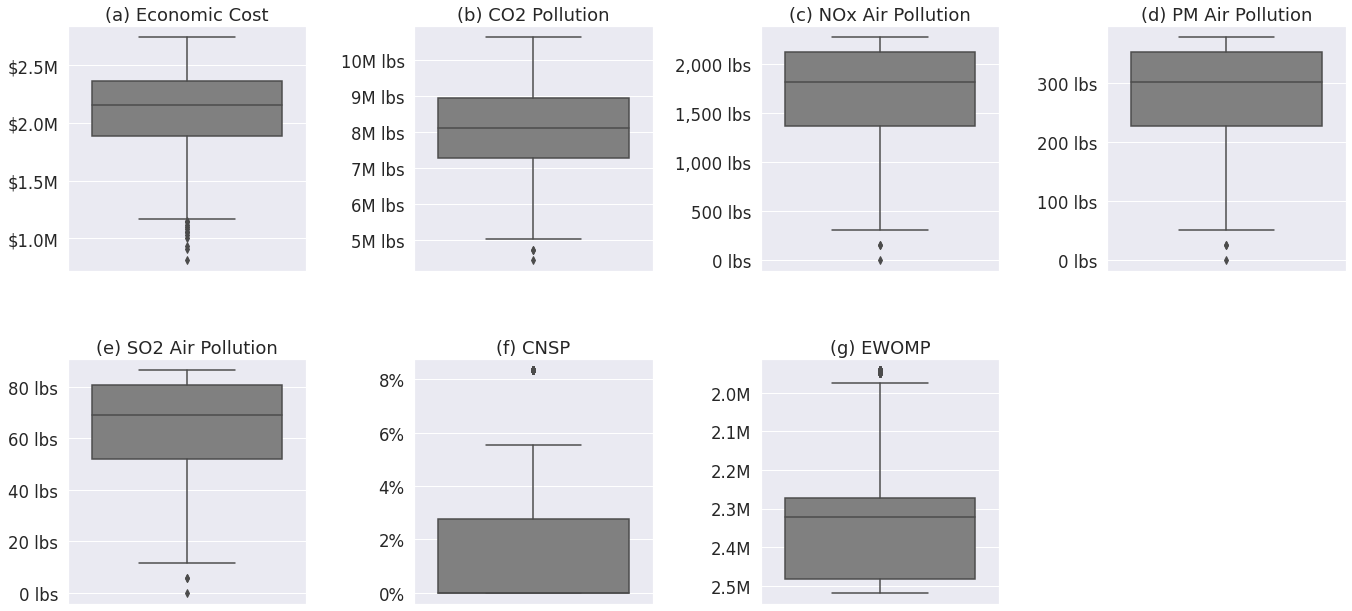

In [32]:
sb.set_theme(font_scale=1.5)

rcParams['figure.facecolor'] = 'white'
create_box_and_whisker_no_buckets(
    network = "RH0_large",
    length="short",
    include = [True, True, True, True, True, True, True],
    figsize=(20,10),
    pad=3,
    datafolder = Path("../../Part A/Data/R1-12.47-2-with-RHs"),
    plotfolder = Path("../../Part A/Images/BoxAndWhiskers"),
    props={'boxprops':{'facecolor':'gray'}},
    save_file=False)